# Projet ML du cours SEC201
- Dataset : [rep Github EMBER](https://github.com/elastic/ember) et [article décrivant le dataset](https://arxiv.org/pdf/1804.04637.pdf)
- Descripteurs : features statiques (informations fichier PE)
- Modèles : différentes approches supervisées 
    - Arbre de décision
    - Bagging Tree
    - Forêt aléatoire
    - KNN
    - régression
    - SVM SVC...

In [1]:
import os
import ember
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from pickle import load
from pickle import dump
from joblib import parallel_backend
import time

In [2]:
data_dir = "../ember2018" #Le dossier contenant les données

In [3]:
#ember.create_vectorized_features(data_dir,2) #Création des features vectorisées à partir des fichiers de données : ne doit être fait qu'une fois

In [4]:
#ember.create_metadata(data_dir) #Création des métadonnées : ne doit être fait qu'une fois

In [3]:
# emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir, feature_version=2) # Chargement des datasets d'entraînement et de test

In [4]:
print(f"Nombre d'observations (qui représentent un software) : {np.size(X_train,0)}")
print(f"Nombre de descripteurs : {np.size(X_train,1)}")

Nombre d'observations (qui représentent un software) : 800000
Nombre de descripteurs : 2381


In [5]:
#On va supprimer les observations qui ne sont pas labellisées (200K qui sont à visée de semi-supervisé, qu'on ne traitera pas dans le cadre de ce projet)
start = time.time()
train_filter = np.where((y_train==0.) | (y_train==1.))
X_train, y_train = X_train[train_filter], y_train[train_filter]
print(f"Nombre d'observations après suppr des non labellisées : {np.size(X_train,0)}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Nombre d'observations après suppr des non labellisées : 600000
Temps d'exe de la cellule : 3.326746940612793


In [8]:
# #On va prendre un subset des données d'entraînement : 600K c'est trop lourd pour ma "petite bécane" sur certains modèles (typiquement SVM), on sélectionne un échantillon de 50K observations
# tirage = np.random.choice(600000,50000,replace=False)
# X_train_sub, y_train_sub = X_train[tirage], y_train[tirage]
# print(f"Nombre d'observations après tirage aléatoire : {np.size(X_train_sub,0)}")

Nombre d'observations après tirage aléatoire : 50000


## Pré traitement : Scaler
On va utiliser un scaler pour standardiser les données, qui peut améliorer certaines approches (notamment la convergence de certains modèles de régression linéaire)

In [9]:
# # on va également scale les données pour certaines des approches qui se servent des données standardisées
# from sklearn.preprocessing import StandardScaler
# start = time.time()
# scaler = StandardScaler()
# X_train_std = scaler.fit_transform(X_train)
# end = time.time()
# print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 24.89741539955139


In [6]:
# #J'exporte le scaler pour pouvoir le récupérer par la suite sans avoir à relancer le calcul...
# from pickle import dump
# with open('scaler.pkl', 'wb') as handle :
#     dump(scaler, handle)

# #Commenté pour éviter le lancement par inadvertance

In [6]:
#On importe le scaler depuis le pickle dump si déjà calculé : données d'entraînement
start = time.time()
with open('scaler.pkl', 'rb') as handle :
    scaler = load(handle)
X_train_std = scaler.transform(X_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 11.244333982467651


In [7]:
#Scale données de test
start = time.time()
X_test_std = scaler.transform(X_test)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 4.162835359573364


## Appoche arbre de décision
On va entraîner un arbre de décision sur les données initiales, sans échantillonage ni standardisation

In [22]:
#Decision Tree
# Créer et entraîner un classifier de type arbre de décision
from sklearn import tree
start = time.time()
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 4939.672164916992


*Il faut environ 1h30 pour entraîner ce simple classifier arbre*

In [23]:
#J'exporte le modèle pour pouvoir le récupérer par la suite sans avoir à reprocess (éventuellement long)...
# from pickle import dump
# with open('tree_clf.pkl', 'wb') as handle :
#     dump(tree_clf, handle)

In [24]:
#Importer depuis le dump pickle
with open('tree_clf.pkl', 'rb') as handle :
    tree_clf = load(handle)

In [25]:
start = time.time()
print(f"Précision de l'abre de décision sur le jeu d'entraînement : {tree_clf.score(X_train,y_train)}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Précision de l'abre de décision sur le jeu d'entraînement : 1.0
Temps d'exe de la cellule : 2.2456157207489014


In [26]:
start = time.time()
pred =tree_clf.predict(X_test)
print(f"Précision de l'abre de décision : {tree_clf.score(X_test,y_test)}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Précision de l'abre de décision : 0.91852
Temps d'exe de la cellule : 1.1967732906341553


La précision du classifier arbre de décision entraîné sur EMBER donne une précision d'environ 92 % sur l'échantillon test (200K observations, dont 100K malveillants et 100K bénins).
Le fait qu'on ait 100% de classif sur l'échantillon initial peut laisser penser à un peu d'overfitting, il n'est pas impossible qu'on puisse améliorer les perfs sur l'échantillon de test en réduisant la taille de l'arbre de décision qu'on produit. Mais il semble plus intéressant de se pencher sur d'autres techniques (Bagging et random forest)

In [27]:
cf_matrix = confusion_matrix(y_test, pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# Lecture : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")

Matrice de confusion : [[0.4604  0.0396 ]
 [0.04188 0.45812]]
Sensibilité : 0.91624
Spécificité : 0.9208
Valeur prédictive positive : 0.9204371936028289
Valeur prédictive négative : 0.9166202118340367
Taux de faux positifs (1-spécificité) : 0.0792
Taux de faux négatifs (1-sensbilité) : 0.08376
Taux de précision : 0.91852


Les perfs du modèle simple arbre sont assez "bonnes" : 8% de faux positifs (c'est beaucoup de fausses alertes pour du malware) et 8% de faux négatifs (ça laisse passer trop de malware sans les détecter)

In [22]:
# Profondeur de notre arbre ?
print(tree_clf.tree_.max_depth)
# 164 : très profond, comme on l'a évoqué, très vraisemblable surapprentissage...

164


## Mauvaise approche : essayer de travailler sur les données sandardisées pour l'arbre de décision : on perd en performance

In [18]:
# #Decision Tree
# # Créer et entraîner un classifier de type arbre de décision sur les données scaled
# from sklearn import tree
# start = time.time()
# tree_clf = tree.DecisionTreeClassifier()
# tree_clf.fit(X_train_sub_std, y_train_sub)
# end = time.time()
# print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 149.49361395835876


In [19]:
# start = time.time()
# print(f"Précision de l'abre de décision sur le jeu d'entraînement : {tree_clf.score(X_train,y_train)}")
# end = time.time()
# print(f"Temps d'exe de la cellule : {end - start}")

Précision de l'abre de décision sur le jeu d'entraînement : 0.69372
Temps d'exe de la cellule : 1.588580846786499


In [20]:
# start = time.time()
# pred =tree_clf.predict(X_test)
# print(f"Précision de l'abre de décision : {tree_clf.score(X_test,y_test)}")
# end = time.time()
# print(f"Temps d'exe de la cellule : {end - start}")

Précision de l'abre de décision : 0.64223
Temps d'exe de la cellule : 0.9692666530609131


In [21]:
# from sklearn.metrics import confusion_matrix
# cf_matrix = confusion_matrix(y_test, pred)
# vn, fp, fn, vp = cf_matrix.ravel()
# print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
# print(f"Sensibilité : {vp/(vp+fn)}")
# print(f"Spécificité : {vn/(vn+fp)}")
# print(f"Valeur prédictive positive : {vp/(vp+fp)}")
# print(f"Valeur prédictive négative : {vn/(vn+fn)}")
# print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
# print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# # Lecture : 
# # Vrai négatif, Faux positif
# # Faux négatif, Vrai positif
# print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")

Matrice de confusion : [[0.18739 0.31261]
 [0.04516 0.45484]]
Sensibilité : 0.90968
Spécificité : 0.37478
Valeur prédictive positive : 0.5926640171998175
Valeur prédictive négative : 0.8058052031821114
Taux de faux positifs (1-spécificité) : 0.62522
Taux de faux négatifs (1-sensbilité) : 0.09032
Taux de précision : 0.64223


## Appoche Bagging tree
On va entraîner un bagging tree sur les données initiales, sans échantillonage ni standardisation

In [13]:
# Approche bagging tree
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
start = time.time()
with parallel_backend('threading', n_jobs=4):
    bag_clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=1/6, n_estimators=100,verbose=3)
    bag_clf.fit(X_train, y_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Building estimator 1 of 25 for this parallel run (total 100)...Building estimator 1 of 25 for this parallel run (total 100)...
Building estimator 1 of 25 for this parallel run (total 100)...
Building estimator 1 of 25 for this parallel run (total 100)...

Building estimator 2 of 25 for this parallel run (total 100)...
Building estimator 2 of 25 for this parallel run (total 100)...
Building estimator 2 of 25 for this parallel run (total 100)...
Building estimator 2 of 25 for this parallel run (total 100)...
Building estimator 3 of 25 for this parallel run (total 100)...
Building estimator 3 of 25 for this parallel run (total 100)...
Building estimator 3 of 25 for this parallel run (total 100)...
Building estimator 3 of 25 for this parallel run (total 100)...
Building estimator 4 of 25 for this parallel run (total 100)...
Building estimator 4 of 25 for this parallel run (total 100)...
Building estimator 4 of 25 for this parallel run (total 100)...
Building estimator 4 of 25 for this para

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 206.4min finished


Temps d'exe de la cellule : 12386.875077486038


In [17]:
# #J'exporte le modèle pour pouvoir le récupérer par la suite sans avoir à reprocess (éventuellement long)...
# from pickle import dump
# with open('bag_clf.pkl', 'wb') as handle :
#     dump(bag_clf, handle)

# #Commenté pour éviter le lancement par erreur

In [ ]:
# #Importer depuis le dump pickle
# from pickle import load
# with open('bag_clf.pkl', 'rb') as handle :
#     bag_clf = load(handle)

# #Commenté pour éviter le lancement par erreur

In [14]:
start = time.time()
with parallel_backend('threading', n_jobs=4):
    print(f"Précision de du classifier bagging sur le jeu d'entraînement : {bag_clf.score(X_train,y_train)}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 15.8min finished


Précision de du classifier bagging sur le jeu d'entraînement : 0.9777716666666667
Temps d'exe de la cellule : 950.2855126857758


In [15]:
start = time.time()
with parallel_backend('threading', n_jobs=4):
    pred =bag_clf.predict(X_test)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Temps d'exe de la cellule : 646.1313645839691


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.8min finished


In [16]:
cf_matrix = confusion_matrix(y_test, pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# Lecture : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")

#On a un taux de précision d'environ 96% avec le bagging : on s'améliore encore, vraiment pas mal
#Le taux de faux positifs de faux négatifs (i.e. les malwares qu'on laisse passer) est proche : environ 4,5 %. Ca reste élevé pour de la vraie détection

Matrice de confusion : [[0.47193  0.02807 ]
 [0.027525 0.472475]]
Sensibilité : 0.94495
Spécificité : 0.94386
Valeur prédictive positive : 0.9439211259726897
Valeur prédictive négative : 0.9448899300237259
Taux de faux positifs (1-spécificité) : 0.05614
Taux de faux négatifs (1-sensbilité) : 0.05505
Taux de précision : 0.944405


## Approche Forêt aléatoire

In [16]:
#Approche Random Forest
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
start = time.time()
with parallel_backend('threading', n_jobs=4):
    forest_clf = RandomForestClassifier(n_estimators=200, verbose=3)
    forest_clf.fit(X_train, y_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 87.9min finished


In [17]:
# #J'exporte le modèle pour pouvoir le récupérer par la suite sans avoir à reprocess (éventuellement long)...
# from pickle import dump
# with open('forest_clf.pkl', 'wb') as handle :
#     dump(forest_clf, handle)

#Commenté pour éviter le lancement par erreur

In [ ]:
#Importer depuis le dump pickle
with open('forest_clf.pkl', 'rb') as handle :
    forest_clf = load(handle)

In [18]:
import time
start = time.time()
with parallel_backend('threading', n_jobs=4):
    forest_score = forest_clf.score(X_train,y_train)
print(f"Précision de du classifier Forêt alétoire sur le jeu d'entraînement : {forest_score}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


Précision de du classifier bagging sur le jeu d'entraînement : 1.0
Temps d'exe de la cellule : 63.60277271270752


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.0min finished


In [19]:
start = time.time()
with parallel_backend('threading', n_jobs=4):
    pred =forest_clf.predict(X_test)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Précision du classifier bagging sur les données de test : 0.953245
Temps d'exe de la cellule : 45.86902666091919


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.2s finished


In [20]:
cf_matrix = confusion_matrix(y_test, pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# Lecture : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")

#On a un taux de précision d'environ 95% avec les forêts aléatoires : on reste proche de ce qu'on trouvait pour le bagging
#On pourrait faire à peu près le même commentaire que dans le cadre du bagging...

Matrice de confusion : [[0.479565 0.020435]
 [0.02632  0.47368 ]]
Sensibilité : 0.94736
Spécificité : 0.95913
Valeur prédictive positive : 0.9586432308268318
Valeur prédictive négative : 0.9479723652608795
Taux de faux positifs (1-spécificité) : 0.04087
Taux de faux négatifs (1-sensbilité) : 0.05264
Taux de précision : 0.953245


## Approche plus proches voisins (K-nearest-neighbors)

In [12]:
#KNN
# Créer et entraîner un classifier de type nearest-neighbor -> très lourd avec 2381 descripteurs, il serait souhaitable de procéder à une sélection en amont ?
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [13]:
start = time.time()
knn.fit(X_train_std,y_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 1.314117193222046


In [12]:
start = time.time()
with parallel_backend('threading', n_jobs=4):
    score_knn = knn.score(X_train_std, y_train)
print(f"Précision sur l'échantillon d'entraînement standardisé : {score_knn}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Précision sur l'échantillon d'entraînement standardisé : 0.9668366666666667
Temps d'exe de la cellule : 42472.25880599022


11 heures d'entraînement pour KNN, une précision de 96,6 % sur les données qui ont servi à la construction

In [14]:
start = time.time()
with parallel_backend('threading', n_jobs=4):
    pred_proba = knn.predict_proba(X_test_std)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")
# Très gros temps de calcul

Temps d'exe de la cellule : 11695.230863332748


4 heures de calcul pour prédire les valeurs de test

In [16]:
# #Sauvegarde des probas de prédictions
# np.savetxt('prediction_proba_KNN.csv',pred_proba,delimiter=',')

# #Commenté pour éviter le lancement par erreur

In [22]:
# #Chargement des prédictions sauvegardées
# pred = np.genfromtxt('prediction_KNN.csv', delimiter=',')
# #Commenté pour éviter le lancement par erreur

In [16]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")
# Lecture matrice de confusion : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")
# Perfs décevantes par rapport aux autres approches...

Matrice de confusion : [[0.46445 0.03555]
 [0.04635 0.45365]]
Sensibilité : 0.9073
Spécificité : 0.9289
Valeur prédictive positive : 0.9273303352412101
Valeur prédictive négative : 0.9092599843382929
Taux de faux positifs (1-spécificité) : 0.0711
Taux de faux négatifs (1-sensbilité) : 0.0927
Taux de précision : 0.9181
Taux de précision : 0.9181


Matrice de confusion : 

| Prédit/Réel | Négatif | Positif |
|---|---|---|
| Négatif | 0.46445 | 0.03555 |
| Positif | 0.04635 | 0.45365 |


Sensibilité : 0.9073

Spécificité : 0.9289

Valeur prédictive positive : 0.9273303352412101

Valeur prédictive négative : 0.9092599843382929

Taux de faux positifs (1-spécificité) : 0.0711

Taux de faux négatifs (1-sensbilité) : 0.0927

Taux de précision : 0.9181

Perfs de 92%, quand même pas mal de faux négatifs (9.2 %) et de faux positifs (7.1%)


## Approche régression logistique

In [54]:
#On va utiliser une régression logistique avec saga sur les données scale
from sklearn.linear_model import LogisticRegression
start = time.time()
#Régression linéare avec solver saga, niveau de verbosité à 3
#Augmenter max_iter car ne converge pas avec la valeur par défaut à 100
with parallel_backend('threading', n_jobs=4):
    reg = LogisticRegression(solver='saga', max_iter=1000, verbose = 3)
    reg.fit(X_train_std, y_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 115 epochs took 2353 seconds
Temps d'exe de la cellule : 2383.7937381267548


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 39.2min finished


In [58]:
# #J'exporte le modèle saga pour pouvoir le récupérer par la suite sans avoir à relancer le calcul...
# from pickle import dump
# with open('reg_saga.pkl', 'wb') as handle :
#     dump(reg, handle)

# # Commenté pour éviter le lancement par erreur

In [ ]:
# from pickle import load
# with open('reg_saga.pkl', 'rb') as handle :
#     reg = load(handle)
# # Commenté pour éviter le lancement par erreur

In [55]:
start = time.time()
score_reg = reg.score(X_train_std,y_train)
print(f"Accurracy sur les données d'entraînement : {score_reg}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Accurracy sur les données d'entraînement : 0.8287966666666666
Temps d'exe de la cellule : 1.997990369796753


In [56]:
#Prédiction à partir du modèle
start = time.time()
with parallel_backend('threading', n_jobs=4):
    reg_pred = reg.predict(X_test_std)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 5.502066373825073


In [57]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, reg_pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# Lecture : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")
# Perfs : 77% de précision, c'est pas génial pour de la détection de malware et inutilisable en pratique...
#En fait, on a beaucoup (trop) de faux positifs... C'est bof aussi au niveau des faux négatifs...

Matrice de confusion : [[0.32676 0.17324]
 [0.05655 0.44345]]
Sensibilité : 0.8869
Spécificité : 0.65352
Valeur prédictive positive : 0.7190808996416351
Valeur prédictive négative : 0.8524692807388276
Taux de faux positifs (1-spécificité) : 0.34648
Taux de faux négatifs (1-sensbilité) : 0.1131
Taux de précision : 0.77021


## Approche SVM (abandonnée)

In [8]:
#On va prendre un subset des données d'entraînement : 600K c'est trop lourd pour ma "petite bécane" pour une approche comme SVM, on sélectionne un échantillon de 50K observations
tirage = np.random.choice(600000,50000,replace=False)
X_train_sub_std, y_train_sub = X_train_std[tirage], y_train[tirage]
print(f"Nombre d'observations après tirage aléatoire : {np.size(X_train_sub_std,0)}")

Nombre d'observations après tirage aléatoire : 50000


In [9]:
# #Sélection de features par SelectKBest
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# start = time.time()
# #Sélection des 100 top  features basée sur mutual info regression
# selector = SelectKBest(mutual_info_classif, k=100)
# selector.fit(X_train_sub_std, y_train)
# end = time.time()
# print(f"Temps d'exe de la cellule : {end - start}")

In [9]:
# Classifier de type SVM
from sklearn import svm
start = time.time()
svm_clf = svm.SVC(verbose=3)
svm_clf.fit(X_train_sub_std, y_train_sub)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[LibSVM]Temps d'exe de la cellule : 1750.352676153183


In [ ]:
#J'exporte le modèle pour pouvoir le récupérer par la suite sans avoir à reprocess (éventuellement long)...
from pickle import dump
with open('svm_clf.pkl', 'wb') as handle :
    dump(svm_clf, handle)

#Commenté pour éviter le lancement par erreur

In [ ]:
#Importer depuis le dump pickle
from pickle import load
with open('svm_clf.pkl', 'rb') as handle :
    svm_clf = load(handle)

In [ ]:
start = time.time()
print(f"Précision sur les données d'entraînement : {svm_clf.score(X_train_sub_std,y_train)}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

In [ ]:
#Prédiction à partir du modèle
start = time.time()
svm_pred = svm_clf.predict(X_test_std)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

In [ ]:
cf_matrix = confusion_matrix(y_test, svm_pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# Lecture : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")

## Bonus : Random Forest avec profondeur limitée à 50

In [39]:
#Approche Random Forest
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
start = time.time()
with parallel_backend('threading', n_jobs=4):
    forest_plus_clf = RandomForestClassifier(n_estimators=200, max_depth=50,  verbose=3)
    forest_plus_clf.fit(X_train, y_train)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")
# bootstrap=True, max_samples=1/3,

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.8min


building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 19.9min


building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 32.7min finished


In [43]:
#J'exporte le modèle pour pouvoir le récupérer par la suite sans avoir à reprocess (éventuellement long)...

with open('forest_plus_clf.pkl', 'wb') as handle :
    dump(forest_plus_clf, handle)

#Commenté pour éviter le lancement par erreur

In [26]:
#Importer depuis le dump pickle
with open('forest_plus_clf.pkl', 'rb') as handle :
    forest_plus_clf = load(handle)

In [40]:
import time
start = time.time()
with parallel_backend('threading', n_jobs=4):
    forest_plus_score = forest_plus_clf.score(X_train,y_train)
print(f"Accuracy du classifier Forêt alétoire sur le jeu d'entraînement : {forest_plus_score}")
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   17.4s


Accuracy du classifier Forêt alétoire sur le jeu d'entraînement : 0.99999
Temps d'exe de la cellule : 30.82383441925049


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   29.2s finished


In [41]:
start = time.time()
with parallel_backend('threading', n_jobs=4):
    pred =forest_plus_clf.predict(X_test)
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.8s


Temps d'exe de la cellule : 10.773161888122559


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.1s finished


In [42]:
cf_matrix = confusion_matrix(y_test, pred)
vn, fp, fn, vp = cf_matrix.ravel()
print(f"Matrice de confusion : {cf_matrix/np.sum(cf_matrix)}")
print(f"Sensibilité : {vp/(vp+fn)}")
print(f"Spécificité : {vn/(vn+fp)}")
print(f"Valeur prédictive positive : {vp/(vp+fp)}")
print(f"Valeur prédictive négative : {vn/(vn+fn)}")
print(f"Taux de faux positifs (1-spécificité) : {fp/(vn+fp)}")
print(f"Taux de faux négatifs (1-sensbilité) : {fn/(vp+fn)}")

# Lecture : 
# Vrai négatif, Faux positif
# Faux négatif, Vrai positif
print(f"Taux de précision : {(cf_matrix[0][0]+cf_matrix[1][1])/np.sum(cf_matrix)}")
# On obtient vraisemblablement un modèle très proche de celui où on ne limite pas la taille des arbres

Matrice de confusion : [[0.47927  0.02073 ]
 [0.025975 0.474025]]
Sensibilité : 0.94805
Spécificité : 0.95854
Valeur prédictive positive : 0.958100473971966
Valeur prédictive négative : 0.9485892982612396
Taux de faux positifs (1-spécificité) : 0.04146
Taux de faux négatifs (1-sensbilité) : 0.05195
Taux de précision : 0.953295


## Comparaison des courbes ROC et AUC des modèles

In [20]:
#Importer les modèles depuis les dump pickles (cette partie a été faite dans un second temps)
start = time.time()

with open('tree_clf.pkl', 'rb') as handle :
    tree_clf = load(handle)
    
with open('bag_clf.pkl', 'rb') as handle :
    bag_clf = load(handle)
    
with open('forest_clf.pkl', 'rb') as handle :
    forest_clf = load(handle)
    
### Pas de modèle à charger avec KNN, on a directement sauvegardé les prédictions ###

with open('reg_saga.pkl', 'rb') as handle :
    reg_clf = load(handle)

with open('forest_plus_clf.pkl', 'rb') as handle :
    forest_plus_clf = load(handle)
    
end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

Temps d'exe de la cellule : 1.055251121520996


In [22]:
#Probas de prédiction à partir des modèles
from sklearn.metrics import roc_curve

import time
start = time.time()

with parallel_backend('threading', n_jobs=4):
    y_pred_tree = tree_clf.predict_proba(X_test)
    #y_pred_bag = bag_clf.predict_proba(X_test)
    y_pred_forest = forest_clf.predict_proba(X_test)
    y_pred_reg = reg_clf.predict_proba(X_test_std)
    y_pred_forestplus = forest_plus_clf.predict_proba(X_test)

y_pred_knn = np.genfromtxt('prediction_proba_KNN.csv', delimiter=',')
    
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_tree[:,1])
fpr_bag, tpr_bag, thresholds_bag = roc_curve(y_test, y_pred_bag[:,1])
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_pred_forest[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn[:,1])
fpr_reg, tpr_reg, thresholds_reg = roc_curve(y_test, y_pred_reg[:,1])
fpr_forestplus, tpr_forestplus, thresholds_forestplus = roc_curve(y_test, y_pred_forestplus[:,1])

end = time.time()
print(f"Temps d'exe de la cellule : {end - start}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.6s finished


Temps d'exe de la cellule : 22.503194093704224


In [23]:
# Calcul des auc
auc_tree = auc(fpr_tree, tpr_tree)
auc_bag = auc(fpr_bag, tpr_bag)
auc_forest = auc(fpr_forest, tpr_forest)
auc_knn = auc(fpr_knn, tpr_knn)
auc_reg = auc(fpr_reg, tpr_reg)
auc_forestplus = auc(fpr_forestplus, tpr_forestplus)

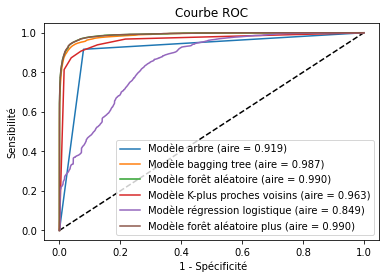

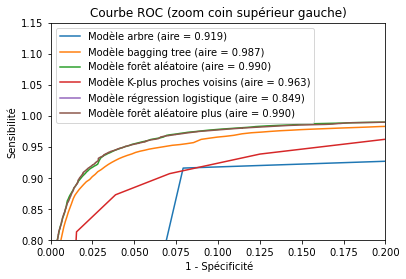

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_tree, tpr_tree, label='Modèle arbre (aire = {:.3f})'.format(auc_tree))
plt.plot(fpr_bag, tpr_bag, label='Modèle bagging tree (aire = {:.3f})'.format(auc_bag))
plt.plot(fpr_forest, tpr_forest, label='Modèle forêt aléatoire (aire = {:.3f})'.format(auc_forest))
plt.plot(fpr_knn, tpr_knn, label='Modèle K-plus proches voisins (aire = {:.3f})'.format(auc_knn))
plt.plot(fpr_reg, tpr_reg, label='Modèle régression logistique (aire = {:.3f})'.format(auc_reg))
plt.plot(fpr_forestplus, tpr_forestplus, label='Modèle forêt aléatoire plus (aire = {:.3f})'.format(auc_forestplus))
plt.xlabel(' 1 - Spécificité')
plt.ylabel('Sensibilité')
plt.title('Courbe ROC')
plt.legend(loc='best')
plt.show()
# Zoom sur le coin gauche supérieur
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.15)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_tree, tpr_tree, label='Modèle arbre (aire = {:.3f})'.format(auc_tree))
plt.plot(fpr_bag, tpr_bag, label='Modèle bagging tree (aire = {:.3f})'.format(auc_bag))
plt.plot(fpr_forest, tpr_forest, label='Modèle forêt aléatoire (aire = {:.3f})'.format(auc_forest))
plt.plot(fpr_knn, tpr_knn, label='Modèle K-plus proches voisins (aire = {:.3f})'.format(auc_knn))
plt.plot(fpr_reg, tpr_reg, label='Modèle régression logistique (aire = {:.3f})'.format(auc_reg))
plt.plot(fpr_forestplus, tpr_forestplus, label='Modèle forêt aléatoire plus (aire = {:.3f})'.format(auc_forestplus))
plt.xlabel(' 1 - Spécificité')
plt.ylabel('Sensibilité')
plt.title('Courbe ROC (zoom coin supérieur gauche)')
plt.legend(loc='best')
plt.show()